In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

In [3]:
# Combine this for a clean initial work of MIAS Classification of N B M, then move on DDSM or mix it up.

# system related
import os
import sys

import tensorflow as tf

# keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.layers import BatchNormalization
from tensorflow.keras import layers, models
from keras.layers import BatchNormalization
from keras import regularizers

# path manipulation
from pathlib import Path

# regex
import re

# image manipulation
from IPython.display import Image

# data manipulation / preparation
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# metrics
from sklearn.metrics import confusion_matrix, classification_report

# data and Image manipulation / preparation
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import itertools

# plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


 ### Citation for the class MammoScan and the collection of functions right after.
*    Title: mias_mammography
*    Author: Poles, Carlos
*    Date: 06/2021
*    Availability: https://github.com/cpoles/data_science/tree/main/projects/deep_learning/mias_mammography/src/modules
* Refere to the sign '*' for citation.

In [4]:
'''
Author: Poles, Carlos *
'''

class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info
    
    @property # scan image
    def scan(self):
        return self.__scan
    
    @property # scan info
    def scan_info(self):
        return self.__sc_info
    
    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name
    
    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x
    
    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y
    
    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class
    
    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg
    
    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property 
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()
    
    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)
    
    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)
        

        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)
    
    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue
    
    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue
    
    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue
        
    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)
            
        return (self.x, 1024.0-self.y, self.radius)
    
    # private method
    def __transform(self):
        '''Creates a dict 
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((256,256))
        # create rotated images
        for angle in (0, 90, 180, 270):
#         for angle in (0, 45, 90, 135, 180, 225, 270, 315):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)
            
            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'], 
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [5]:
'''
Author: Poles, Carlos *
'''
def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index
    
    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)
    
    return new_df


def delete_image(filename: str, directory='../all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}') 
            
            
def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()
    
    return img_dic
        

def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
    '''Save subsamples to the subsamples folder'''
    # define subsamples folder
    folder = '../subsamples'
    df_sub = pd.DataFrame()
    try:
        # create if not yet
        if not os.path.exists(folder):
            os.mkdir(folder)
    except:
        print('An error occurred when searching for the folder')
        
    # iterate dictionary of filenames
    for scan_name, filename in scans_dic.items():
        
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = df.loc[scan_name].copy()
        # create the MammoScan object
        m_scan = MammoScan(scan, scan_info)
        # get the transformations
        transf_scans = m_scan.transformations
        # create filenames
        filenames = create_subsample_filename(scan_name, transf_scans)
        # get transformed scans Image objects
        imgs = get_transformed_scans(transf_scans)
        # prepare for saving
        fs_and_is = list(zip(filenames, imgs))
        
        for filename, image in fs_and_is:
            # create new observation with subsample name
            # name the series to become an index in the new dataframe
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            # create pixel matrix
            pixel_matrix = np.asarray(image)
            
            scan_info['p_matrix'] = pixel_matrix
            
            scan_info['subsample_path'] = os.path.join('../subsamples', filename)

            # append to dataframe
            df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg', 
                                                  'severity', 'subsample_path',
                                                  'p_matrix']])
            
            #print(scan_name)././
            path = os.path.join('../subsamples', filename) 
            #print(path)
            try:
                image.save(path, compress_level=0)
            except ValueError as ve:
                print('Output format could not be determined from the file name.')
            except OSError as ose:
                print('File could not be written.')
                print({ose})
        
    return df_sub


def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''
            
    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)
    
    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)   
    
    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']
    
    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)
        
    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('N')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)
    
    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')
    
    
    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()
    
    
def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(864, replace = True) # Changed from 96 and replace False
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(144, replace = True)
            class_df_A = class_df[class_df.severity == 'M'].sample(144, replace = True)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)
""
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')
        
def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])


In [6]:
mammo = create_mias_dataset("../input/mias-mammography/Info.txt")
mammo

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,N,NaN,NaN,NaN
mdb004,D,NORM,N,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,N,NaN,NaN,NaN
mdb319,D,NORM,N,NaN,NaN,NaN
mdb320,D,NORM,N,NaN,NaN,NaN


In [7]:
mias = generate_subsamples("../input/mias-mammography/all-mias/", mammo)
mias

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.


,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ..."
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,..."
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,..."
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ..."
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,N,../subsamples/mdb322_180_mirr_lr.png,"[[193, 193, 192, 191, 191, 192, 193, 194, 195,..."
mdb322_180_mirr_tp,NORM,D,N,../subsamples/mdb322_180_mirr_tp.png,"[[206, 206, 206, 205, 205, 205, 206, 206, 207,..."
mdb322_270_rotated,NORM,D,N,../subsamples/mdb322_270_rotated.png,"[[193, 193, 194, 195, 194, 192, 190, 190, 191,..."
mdb322_270_mirr_lr,NORM,D,N,../subsamples/mdb322_270_mirr_lr.png,"[[172, 172, 173, 175, 175, 175, 174, 174, 175,..."


In [32]:
from PIL import Image
import glob
import cv2

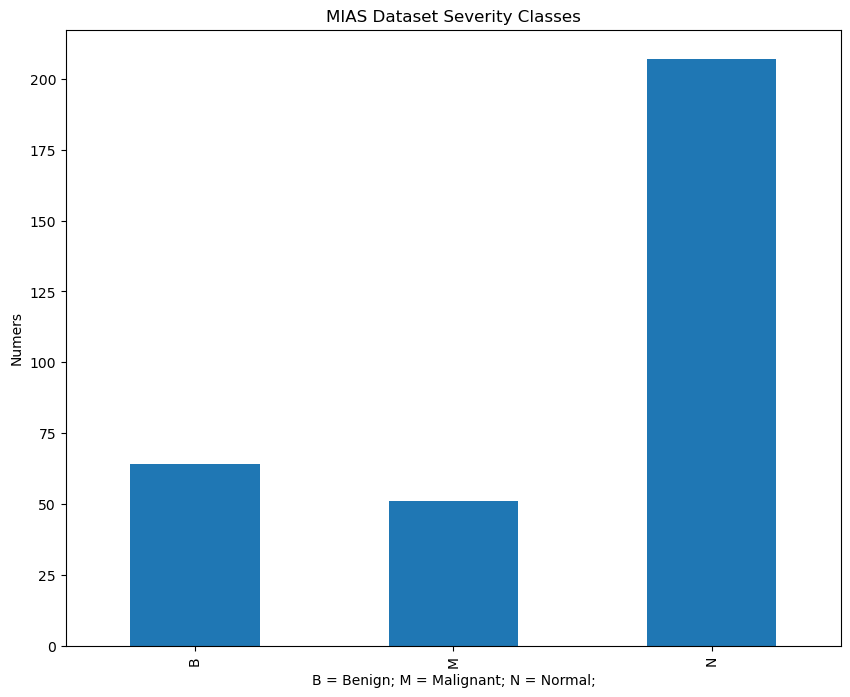

In [33]:
mammo.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant; N = Normal;', 
                                                 ylabel='Numers',
                                                 title='MIAS Dataset Severity Classes');
plt.savefig('MIAS Dataset Distribution.png')

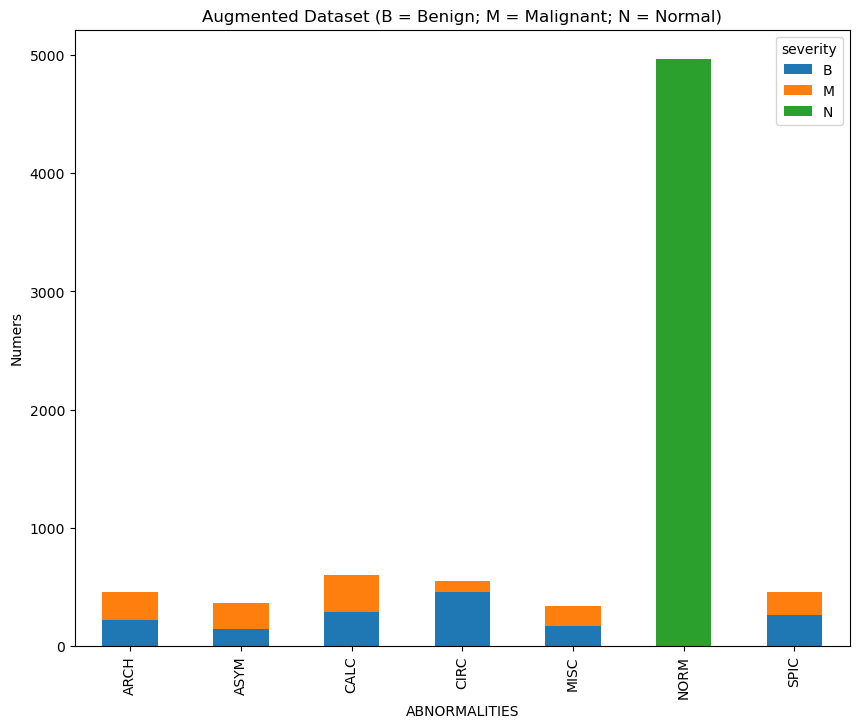

In [34]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numers',
                                                              title='Augmented Dataset (B = Benign; M = Malignant; N = Normal)');

In [8]:
all_mias_full = full_balance_df_by_severity(mias)
all_mias_full

,ab_class,bg,severity,subsample_path,p_matrix
mdb312_180_mirr_tp,MISC,F,B,../subsamples/mdb312_180_mirr_tp.png,"[[184, 184, 184, 184, 184, 184, 184, 185, 185,..."
mdb241_270_mirr_lr,CALC,D,M,../subsamples/mdb241_270_mirr_lr.png,"[[34, 34, 34, 34, 34, 34, 35, 36, 37, 37, 36, ..."
mdb023_270_rotated,CIRC,G,M,../subsamples/mdb023_270_rotated.png,"[[160, 160, 160, 160, 161, 161, 161, 161, 161,..."
mdb184_0_mirr_lr,SPIC,F,M,../subsamples/mdb184_0_mirr_lr.png,"[[159, 155, 155, 155, 153, 151, 150, 152, 150,..."
mdb053_90_mirr_lr,NORM,D,N,../subsamples/mdb053_90_mirr_lr.png,"[[197, 197, 199, 200, 201, 202, 202, 202, 201,..."
...,...,...,...,...,...
mdb090_90_rotated,ASYM,G,M,../subsamples/mdb090_90_rotated.png,"[[82, 82, 84, 86, 86, 86, 85, 84, 83, 83, 83, ..."
mdb309_180_mirr_tp,NORM,F,N,../subsamples/mdb309_180_mirr_tp.png,"[[148, 148, 148, 148, 148, 147, 147, 147, 148,..."
mdb107_180_mirr_lr,ASYM,D,B,../subsamples/mdb107_180_mirr_lr.png,"[[213, 214, 214, 214, 213, 212, 212, 212, 212,..."
mdb072_0_mirr_lr,ASYM,G,M,../subsamples/mdb072_0_mirr_lr.png,"[[178, 178, 178, 178, 178, 179, 179, 179, 180,..."


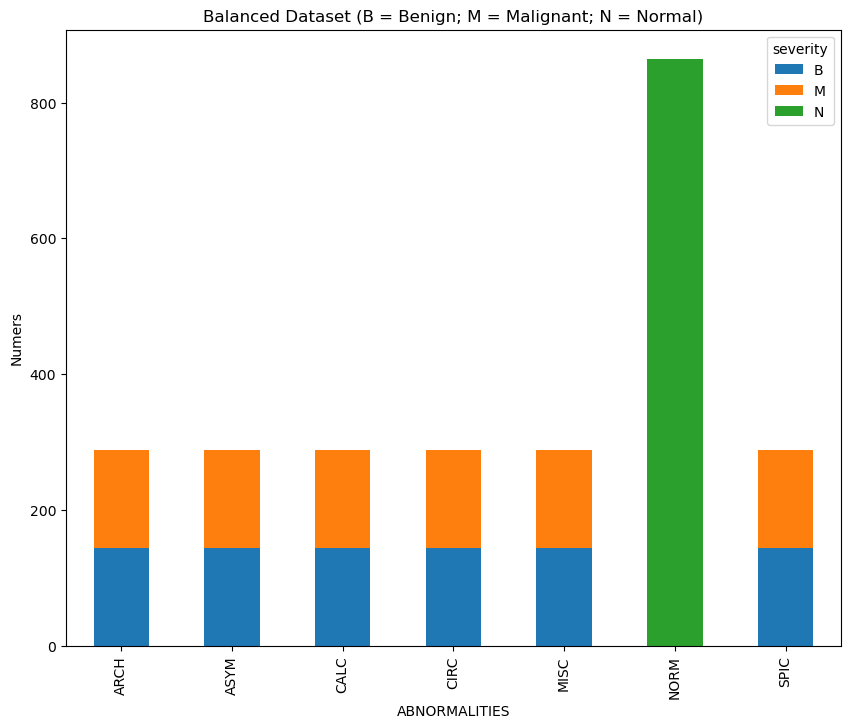

In [36]:
all_mias_full.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numers',
                                                              title='Balanced Dataset (B = Benign; M = Malignant; N = Normal)');

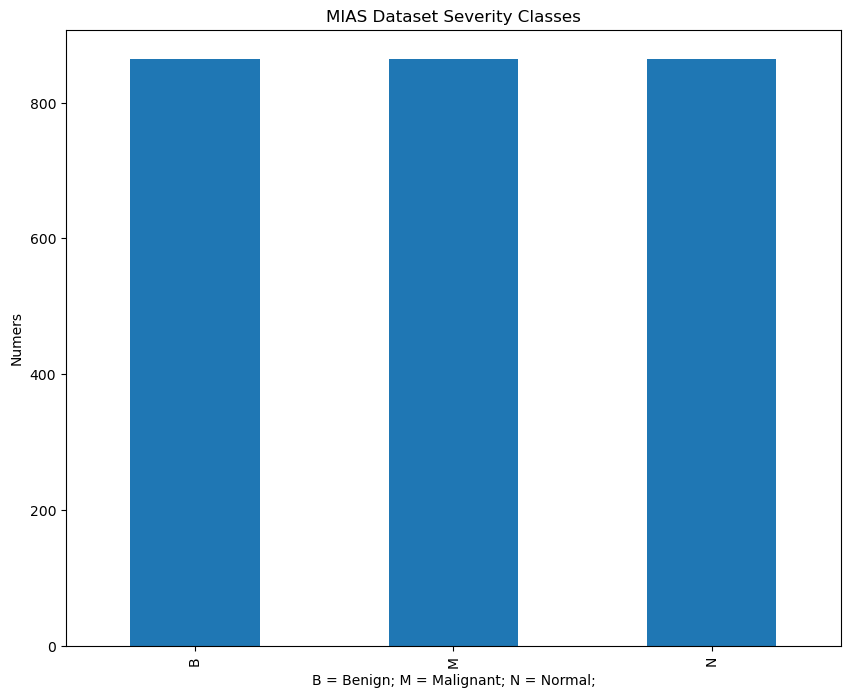

In [37]:
all_mias_full.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant; N = Normal;', 
                                                 ylabel='Numers',
                                                 title='MIAS Dataset Severity Classes');

In [38]:
info=pd.read_csv("../input/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna('N')

0      B
1      B
2      N
3      N
4      B
      ..
325    N
326    N
327    N
328    N
329    N
Name: SEVERITY, Length: 330, dtype: object

In [39]:
# sns.set_style('darkgrid')
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
# sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
# sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)

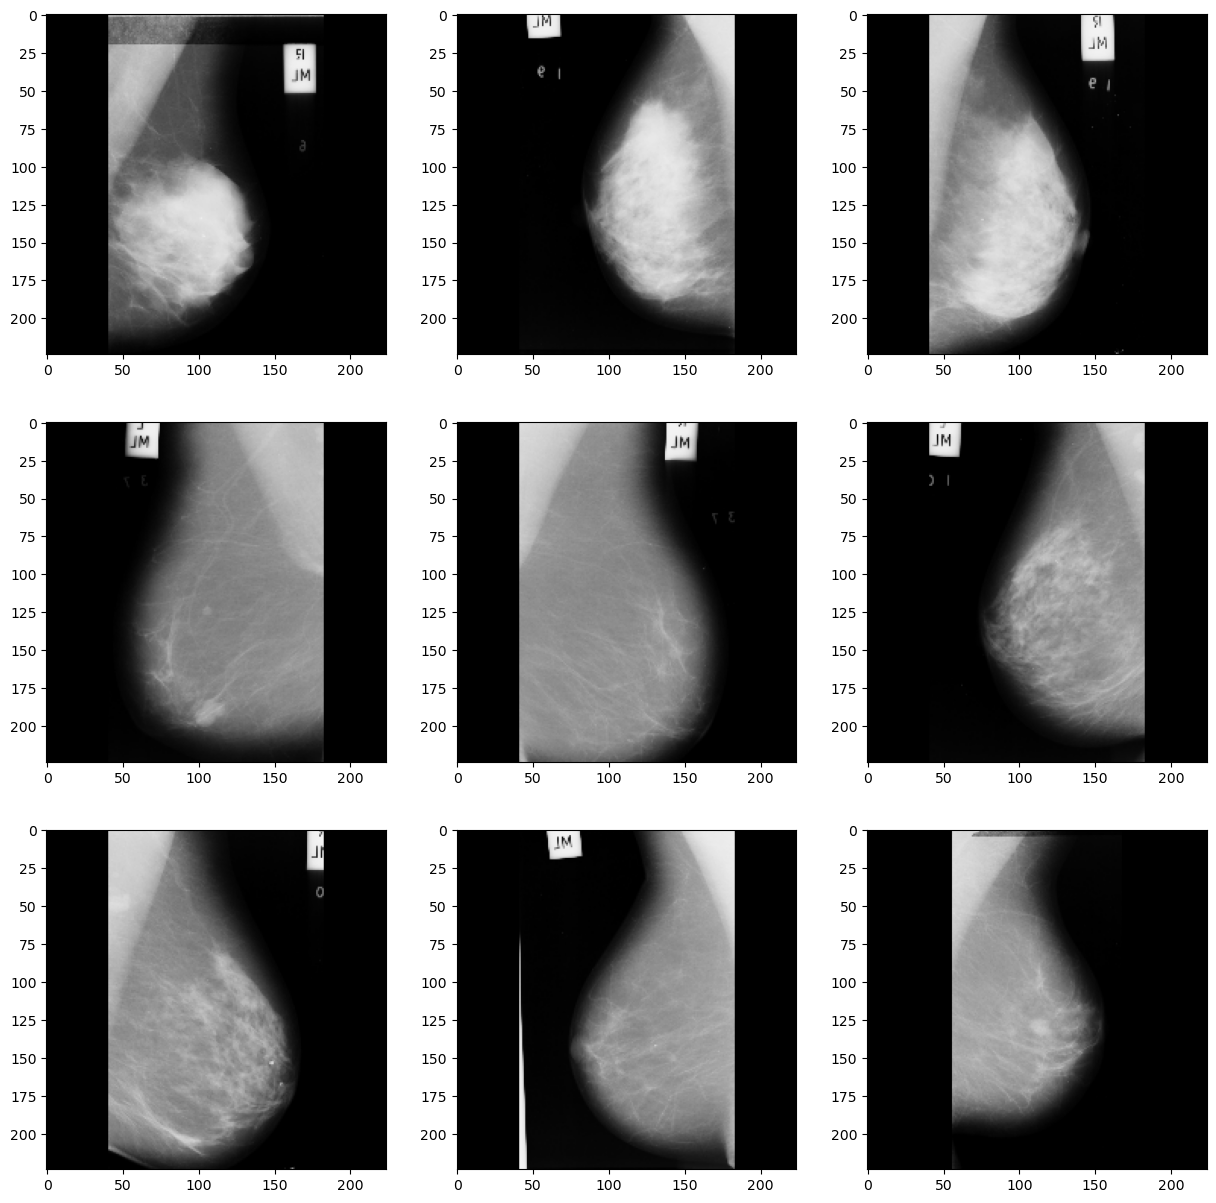

In [40]:
from PIL import Image
import glob
import cv2
x= []
for filename in sorted(glob.glob("../input/mias-mammography/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [9]:
data_df = all_mias_full
# Split data into training, validation, and testing sets
train_df, val_test_df = train_test_split(data_df, test_size=0.25, stratify=data_df['severity'])
val_df, test_df = train_test_split(val_test_df, test_size=0.2, stratify=val_test_df['severity'])

# Define data generators
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                  height_shift_range=.10, 
                                  width_shift_range=.10, 
                                  rotation_range=30, 
                                  rescale=1/255.)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
                                   
# Define image size and batch size
img_size = (48, 48)
batch_size = 32
color_mode = 'rgb'

# Training data generator
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'subsample_path',
    y_col = 'severity',
    target_size  =img_size,
    batch_size = batch_size,
    class_mode ='categorical',
    color_mode = color_mode,
    shuffle = True
)

# Validation data generator
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = 'subsample_path',
    y_col = 'severity',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = color_mode,
    shuffle=False
)

# Testing data generator
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'subsample_path',
    y_col = 'severity',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = color_mode,
    shuffle=False
)

# Get the true class labels for the testing data
test_label = test_data.labels

Found 1944 validated image filenames belonging to 3 classes.
Found 518 validated image filenames belonging to 3 classes.
Found 130 validated image filenames belonging to 3 classes.


In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
# We use include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable.
vgg16_base = VGG16(weights = "imagenet", include_top=False, input_shape=(48, 48, 3), pooling='max')
vgg16_base.trainable = False ## Not trainable weights
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten())
# vgg16.add(BatchNormalization())
vgg16.add(Dense(512, activation = 'relu')) 
# vgg16.add(Dropout(0.25))
# vgg16.add(Dense(128, activation = 'relu', activity_regularizer = regularizers.l2(1e-5))) 
# vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.25))
vgg16.add(Dense(3, activation='softmax'))
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,978,883
Trainable params: 264,195
Non-trainable params: 14,714,688
_______________________________________

In [44]:
# from keras.utils import to_categorical
# # Image Augmentation
# no_angles = 360
# url = '/kaggle/input/mias-mammography/all-mias/'

# def save_dictionary(path,data):
#         print('saving catalog...')
#         #open('u.item', encoding="utf-8")
#         import json
#         with open(path,'w') as outfile:
#             json.dump(str(data), fp=outfile)
#         # save to file:
#         print(' catalog saved')
# # train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# # val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# # test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# def read_image():
#         print("Reading images")
#         import cv2
#         info = {}
#         for i in range(322):
#             if i<9:
#                 image_name='mdb00'+str(i+1)
#             elif i<99:
#                 image_name='mdb0'+str(i+1)
#             else:
#                 image_name = 'mdb' + str(i+1)
#             image_address= url+image_name+'.pgm'
#             img = cv2.imread(image_address,1)
#             img = cv2.resize(img, (224,224))
#             rows, cols,channel = img.shape
#             info[image_name]={}
#             for angle in range(0,no_angles,8):
#                 M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
#                 img_rotated = cv2.warpAffine(img, M, (cols, rows))
#                 info[image_name][angle]=img_rotated
#         return (info)
# def read_lable():
#     print("Reading labels")
#     filename = url+'Info.txt'
#     text_all = open(filename).read()
#     #print(text_all)
#     lines=text_all.split('\n')
#     info={}
#     for line in lines:
#         words=line.split(' ')       
#         if len(words)>3:
#             if (words[3] == 'B'):
#                 info[words[0]] = {}
#                 for angle in range(0,no_angles,8):
#                     info[words[0]][angle] = 0
#             if (words[3] == 'M'):
#                 info[words[0]] = {}
#                 for  angle in range(0,no_angles,8):
#                     info[words[0]][angle] = 1
#     return (info)
# import numpy as np
# lable_info=read_lable()
# image_info=read_image()
# ids=lable_info.keys() 
# del lable_info['Truth-Data:']
# X=[]
# Y=[]
# for id in ids:
#     for angle in range(0,no_angles,8):
#         X.append(image_info[id][angle])
#         Y.append(lable_info[id][angle])
# X=np.array(X)
# Y=np.array(Y)
# Y=to_categorical(Y,3)
# x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
# print(len(x_train),len(x_val),len(x_test))

Reading labels
Reading images
3622 1087 466


In [45]:
# base_model_resnet50 = ResNet50(weights = "imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model_resnet50.trainable = False ## Not trainable weights
# resnet50=Sequential()
# resnet50.add(base_model_resnet50)
# resnet50.add(Flatten())
# resnet50.add(BatchNormalization())
# resnet50.add(Dense(64, activation = 'relu', kernel_initializer='he_uniform'))
# resnet50.add(BatchNormalization())
# # resnet50.add(Activation('relu'))
# resnet50.add(Dropout(0.25))
# resnet50.add(Dense(3,activation='softmax'))

In [46]:
# c2=tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=6,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# c3=tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.1,
#     patience=6,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0.001
# )
# nClasses=3

In [47]:
# resnet50.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
# history=resnet50.fit(x_train,y_train,epochs=10,callbacks=[c2,c3],batch_size=16)

In [12]:
adam = Adam(0.001)

vgg16.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=["accuracy"])


early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

model_checkpoint_vgg16 = ModelCheckpoint(filepath= './best_vgg16.h5', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')

# fit the model
hist_vgg16 = vgg16.fit(train_data, validation_data=val_data, 
                           epochs=500, callbacks=[early_stopping, model_checkpoint_vgg16])
# Val loss .64 with 7k samples and 2 FC

Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 1.0359 - accuracy: 0.4594
Epoch 1: val_loss improved from inf to 0.89992, saving model to ./best_vgg16.h5
61/61 [==============================] - 15s 112ms/step - loss: 1.0359 - accuracy: 0.4594 - val_loss: 0.8999 - val_accuracy: 0.5444
Epoch 2/500
61/61 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.5278
Epoch 2: val_loss improved from 0.89992 to 0.83751, saving model to ./best_vgg16.h5
61/61 [==============================] - 5s 90ms/step - loss: 0.9465 - accuracy: 0.5278 - val_loss: 0.8375 - val_accuracy: 0.6042
Epoch 3/500
61/61 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.5674
Epoch 3: val_loss improved from 0.83751 to 0.80993, saving model to ./best_vgg16.h5
61/61 [==============================] - 6s 91ms/step - loss: 0.9005 - accuracy: 0.5674 - val_loss: 0.8099 - val_accuracy: 0.6236
Epoch 4/500
61/61 [==============================] - ETA: 0s - loss: 0.8777

In [17]:
# predictions
predictions = vgg16.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels

# Evaluation Results
loss_value, accuracy = vgg16.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')
# B, M or N
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

61/61 [==============================] - 4s 69ms/step - loss: 0.2576 - accuracy: 0.9012
Test loss_value: 0.2576088309288025
Test accuracy: 0.9012345671653748
Classes: {'B': 0, 'M': 1, 'N': 2}

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        43
           1       0.91      0.93      0.92        43
           2       0.91      0.95      0.93        44

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.91       130
weighted avg       0.92      0.92      0.91       130



In [18]:
models.save_model(vgg16, 'vgg16.h5')

In [15]:
# # History of accuracy and loss
# tra_loss = history_vgg16.history['loss']
# tra_acc = history_vgg16.history['accuracy']
# val_loss = history_vgg16.history['val_loss']
# val_acc = history_vgg16.history['val_accuracy']

# # Total number of epochs training
# epochs = range(1, len(tra_acc)+1)
# end_epoch = len(tra_acc)

# # Epoch when reached the validation loss minimum
# opt_epoch = val_loss.index(min(val_loss)) + 1

# # Loss and accuracy on the validation set
# end_val_loss = val_loss[-1]
# end_val_acc = val_acc[-1]
# opt_val_loss = val_loss[opt_epoch-1]
# opt_val_acc = val_acc[opt_epoch-1]

# # Loss and accuracy on the test set
# opt_model = models.load_model('./best_vgg16.h5')
# test_loss, test_acc = vgg16.evaluate(train_data, verbose=False)
# opt_test_loss, opt_test_acc = opt_model.evaluate(test_data, verbose=False)

# print("Model Result\n")
# print("Epoch [end]: %d" % end_epoch)
# print("Epoch [opt]: %d\n" % opt_epoch)
# print("Valid accuracy [end]: %.4f" % end_val_acc)
# print("Valid accuracy [opt]: %.4f" % opt_val_acc)
# print("Test accuracy [end]:  %.4f" % test_acc)
# print("Test accuracy [opt]:  %.4f\n" % opt_test_acc)
# print("Valid loss [end]: %.4f" % end_val_loss)
# print("Valid loss [opt]: %.4f" % opt_val_loss)
# print("Test loss [end]:  %.4f" % test_loss)
# print("Test loss [opt]:  %.4f" % opt_test_loss)

In [26]:
# History of accuracy and loss
tra_loss_vgg16 = hist_vgg16.history['loss']
tra_acc_vgg16 = hist_vgg16.history['accuracy']
val_loss_vgg16 = hist_vgg16.history['val_loss']
val_acc_vgg16 = hist_vgg16.history['val_accuracy']

# Total number of epochs training
epochs_vgg16 = range(1, len(tra_acc_vgg16)+1)
end_epoch_vgg16 = len(tra_acc_vgg16)

# Epoch when reached the validation loss minimum
opt_epoch_vgg16 = val_loss_vgg16.index(min(val_loss_vgg16)) + 1

# Loss and accuracy on the validation set
end_val_loss_vgg16 = val_loss_vgg16[-1]
end_val_acc_vgg16 = val_acc_vgg16[-1]
opt_val_loss_vgg16 = val_loss_vgg16[opt_epoch_vgg16-1]
opt_val_acc_vgg16 = val_acc_vgg16[opt_epoch_vgg16-1]

# Loss and accuracy on the test set
opt_model_vgg16 = models.load_model('./best_vgg16.h5')
test_loss_vgg16, test_acc_vgg16 = vgg16.evaluate(test_data, verbose=False)
opt_test_loss_vgg16, opt_test_acc_vgg16 = opt_model_vgg16.evaluate(test_data, verbose=False)
opt_pred_vgg16 = opt_model_vgg16.predict(test_data)
pred_classes_vgg16 = np.argmax(opt_model_vgg16.predict(test_data), axis=-1)

print("Model VGG16 [48x48]\n")

print("Epoch [end]: %d" % end_epoch_vgg16)
print("Epoch [opt]: %d\n" % opt_epoch_vgg16)
print("Valid accuracy [end]: %.4f" % end_val_acc_vgg16)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_vgg16)
print("Test accuracy [end]:  %.4f" % test_acc_vgg16)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_vgg16)
print("Valid loss [end]: %.4f" % end_val_loss_vgg16)
print("Valid loss [opt]: %.4f" % opt_val_loss_vgg16)
print("Test loss [end]:  %.4f" % test_loss_vgg16)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_vgg16)

print(classification_report(test_label, pred_classes_vgg16, digits=4))

5/5 [==============================] - 0s 34ms/step
Model VGG16 [48x48]

Epoch [end]: 500
Epoch [opt]: 499

Valid accuracy [end]: 0.8919
Valid accuracy [opt]: 0.9054
Test accuracy [end]:  0.9154
Test accuracy [opt]:  0.9154

Valid loss [end]: 0.2919
Valid loss [opt]: 0.2344
Test loss [end]:  0.3505
Test loss [opt]:  0.2977

              precision    recall  f1-score   support

           0     0.9487    0.8605    0.9024        43
           1     0.9524    0.9302    0.9412        43
           2     0.8571    0.9545    0.9032        44

    accuracy                         0.9154       130
   macro avg     0.9194    0.9151    0.9156       130
weighted avg     0.9189    0.9154    0.9155       130



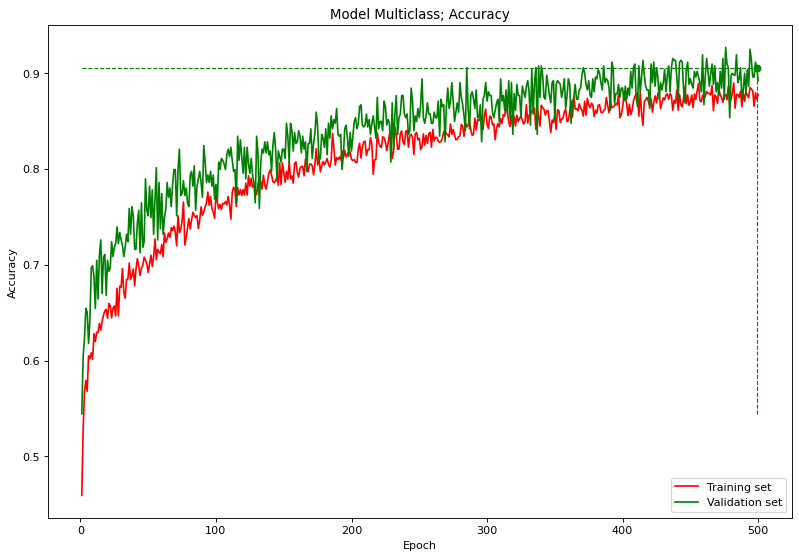

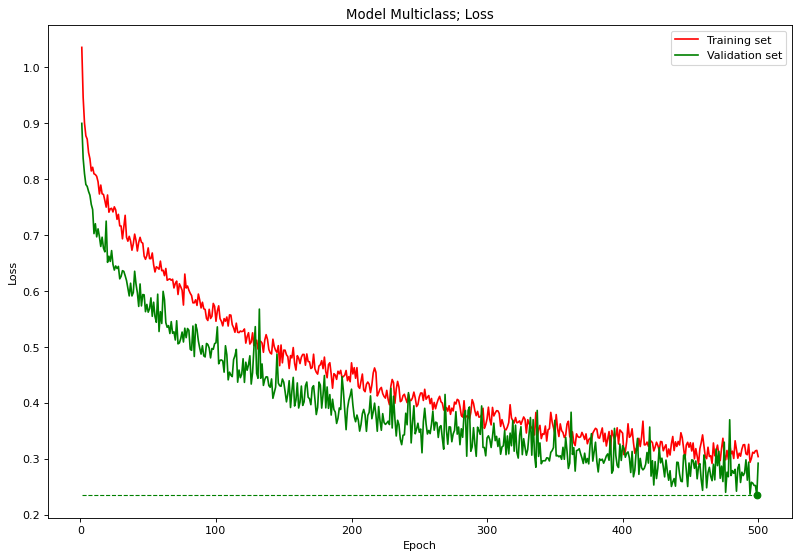

In [27]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_vgg16, tra_acc_vgg16, 'r', label='Training set')
plt.plot(epochs_vgg16, val_acc_vgg16, 'g', label='Validation set')
plt.plot(opt_epoch_vgg16, val_acc_vgg16[opt_epoch_vgg16-1], 'go')
plt.vlines(opt_epoch_vgg16, min(val_acc_vgg16), opt_val_acc_vgg16, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_vgg16, 1, opt_epoch_vgg16, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('ModelVGG16Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Multiclass; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_vgg16, tra_loss_vgg16, 'r', label='Training set')
plt.plot(epochs_vgg16, val_loss_vgg16, 'g', label='Validation set')
plt.plot(opt_epoch_vgg16, val_loss_vgg16[opt_epoch_vgg16-1], 'go')
plt.vlines(opt_epoch_vgg16, min(val_loss_vgg16), opt_val_loss_vgg16, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_vgg16, 1, opt_epoch_vgg16, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('ModelVGG16Loss_figure.png')

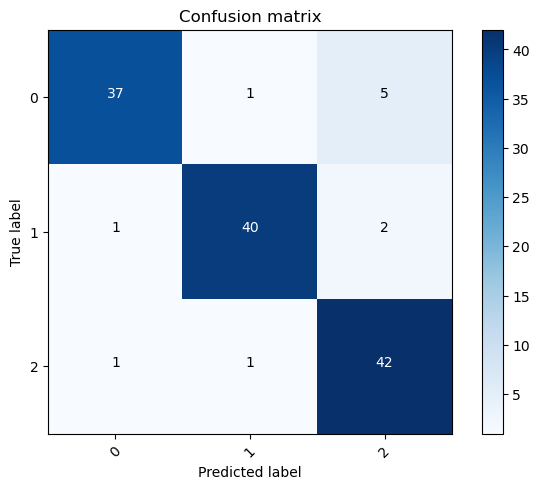

In [35]:
confusion_mtx = confusion_matrix(test_label, pred_classes_vgg16) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrixVGG16.png')

In [36]:
# We use include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable.
resnet50_base = ResNet50(weights = "imagenet", include_top=False, input_shape=(48, 48, 3))
resnet50_base.trainable = False ## Not trainable weights

resnet50 = Sequential()
resnet50.add(vgg16_base)
resnet50.add(Flatten())
# resnet50.add(BatchNormalization())
resnet50.add(Dense(256, activation = 'relu'))
# resnet50.add(BatchNormalization())
# resnet50.add(Dropout(0.25))
resnet50.add(Dense(3, activation='softmax'))
resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 14,846,787
Trainable params: 132,099
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
adam = Adam(0.001)

resnet50.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=["accuracy"])


early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

model_checkpoint_resnet50 = ModelCheckpoint(filepath= './best_resnet50.h5', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist_resnet50 = resnet50.fit(train_data, validation_data=val_data, 
                           epochs=500, callbacks=[early_stopping, model_checkpoint_resnet50])

Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 1.0148 - accuracy: 0.4794
Epoch 1: val_loss improved from inf to 0.90816, saving model to ./best_resnet50.h5
61/61 [==============================] - 6s 89ms/step - loss: 1.0148 - accuracy: 0.4794 - val_loss: 0.9082 - val_accuracy: 0.5598
Epoch 2/500
61/61 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 0.5448
Epoch 2: val_loss improved from 0.90816 to 0.82977, saving model to ./best_resnet50.h5
61/61 [==============================] - 5s 81ms/step - loss: 0.9308 - accuracy: 0.5448 - val_loss: 0.8298 - val_accuracy: 0.6100
Epoch 3/500
61/61 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.5700
Epoch 3: val_loss improved from 0.82977 to 0.80768, saving model to ./best_resnet50.h5
61/61 [==============================] - 5s 84ms/step - loss: 0.9009 - accuracy: 0.5700 - val_loss: 0.8077 - val_accuracy: 0.6293
Epoch 4/500
61/61 [==============================] - ETA: 0s - loss:

In [38]:
models.save_model(resnet50, 'resnet50.h5')

In [41]:
# History of accuracy and loss
tra_loss_resnet50 = hist_resnet50.history['loss']
tra_acc_resnet50 = hist_resnet50.history['accuracy']
val_loss_resnet50 = hist_resnet50.history['val_loss']
val_acc_resnet50 = hist_resnet50.history['val_accuracy']

# Total number of epochs training
epochs_resnet50 = range(1, len(tra_acc_resnet50)+1)
end_epoch_resnet50 = len(tra_acc_resnet50)

# Epoch when reached the validation loss minimum
opt_epoch_resnet50 = val_loss_resnet50.index(min(val_loss_resnet50)) + 1

# Loss and accuracy on the validation set
end_val_loss_resnet50 = val_loss_resnet50[-1]
end_val_acc_resnet50 = val_acc_resnet50[-1]
opt_val_loss_resnet50 = val_loss_resnet50[opt_epoch_resnet50-1]
opt_val_acc_resnet50 = val_acc_resnet50[opt_epoch_resnet50-1]

# Loss and accuracy on the test set
opt_model_resnet50 = models.load_model('./best_resnet50.h5')
test_loss_resnet50, test_acc_resnet50 = resnet50.evaluate(test_data, verbose=False)
opt_test_loss_resnet50, opt_test_acc_resnet50 = opt_model_resnet50.evaluate(test_data, verbose=False)
opt_pred_resnet50 = opt_model_resnet50.predict(test_data)
pred_classes_resnet50 = np.argmax(opt_model_resnet50.predict(test_data), axis=-1)

print("Model 0 [48x48]\n")

print("Epoch [end]: %d" % end_epoch_resnet50)
print("Epoch [opt]: %d\n" % opt_epoch_resnet50)
print("Valid accuracy [end]: %.4f" % end_val_acc_resnet50)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_resnet50)
print("Test accuracy [end]:  %.4f" % test_acc_resnet50)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_resnet50)
print("Valid loss [end]: %.4f" % end_val_loss_resnet50)
print("Valid loss [opt]: %.4f" % opt_val_loss_resnet50)
print("Test loss [end]:  %.4f" % test_loss_resnet50)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_resnet50)

print(classification_report(test_label, pred_classes_resnet50, digits=4))

5/5 [==============================] - 0s 33ms/step
Model 0 [48x48]

Epoch [end]: 500
Epoch [opt]: 490

Valid accuracy [end]: 0.8900
Valid accuracy [opt]: 0.9421
Test accuracy [end]:  0.8923
Test accuracy [opt]:  0.9538

Valid loss [end]: 0.2629
Valid loss [opt]: 0.2096
Test loss [end]:  0.3237
Test loss [opt]:  0.2768

              precision    recall  f1-score   support

           0     0.9333    0.9767    0.9545        43
           1     0.9756    0.9302    0.9524        43
           2     0.9545    0.9545    0.9545        44

    accuracy                         0.9538       130
   macro avg     0.9545    0.9538    0.9538       130
weighted avg     0.9545    0.9538    0.9538       130



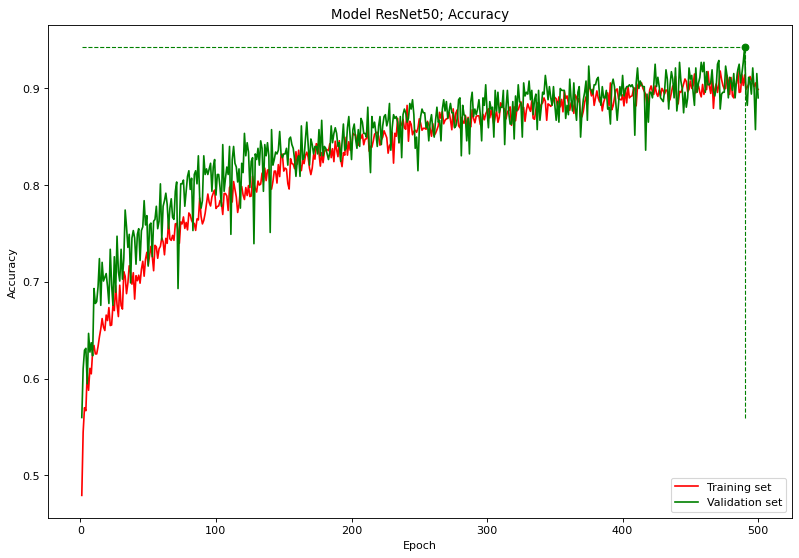

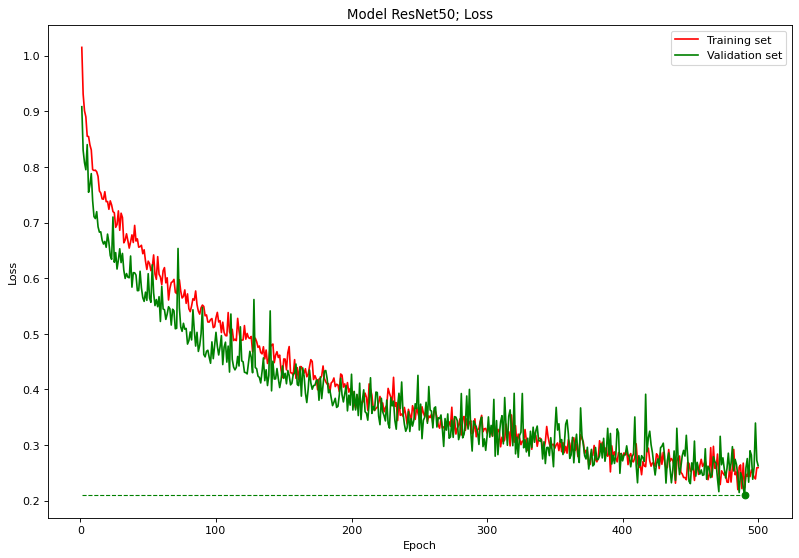

In [53]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model ResNet50; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_resnet50, tra_acc_resnet50, 'r', label='Training set')
plt.plot(epochs_resnet50, val_acc_resnet50, 'g', label='Validation set')
plt.plot(opt_epoch_resnet50, val_acc_resnet50[opt_epoch_resnet50-1], 'go')
plt.vlines(opt_epoch_resnet50, min(val_acc_resnet50), opt_val_acc_resnet50, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_resnet50, 1, opt_epoch_resnet50, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('ResNet50Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model ResNet50; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_resnet50, tra_loss_resnet50, 'r', label='Training set')
plt.plot(epochs_resnet50, val_loss_resnet50, 'g', label='Validation set')
plt.plot(opt_epoch_resnet50, val_loss_resnet50[opt_epoch_resnet50-1], 'go')
plt.vlines(opt_epoch_resnet50, min(val_loss_resnet50), opt_val_loss_resnet50, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_resnet50, 1, opt_epoch_resnet50, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('ResNet50Loss_figure.png')

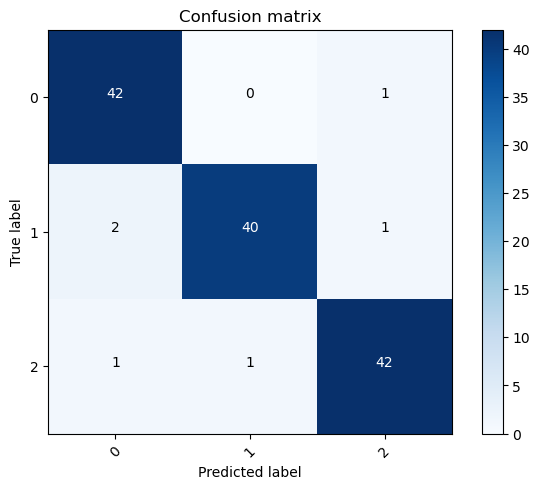

In [43]:
confusion_mtx = confusion_matrix(test_label, pred_classes_resnet50) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrixResNet50.png')

## Trial 1 VGG16

In [44]:
# vgg16_base = VGG16(weights = "imagenet", include_top=False, input_shape=(48, 48, 3), pooling='max')
# vgg16_base.trainable = False ## Not trainable weights
vgg16_1 = Sequential()
vgg16_1.add(vgg16_base)
vgg16_1.add(Flatten())
# vgg16.add(BatchNormalization())
vgg16_1.add(Dense(256, activation = 'relu')) 
# vgg16.add(Dropout(0.25))
# vgg16.add(Dense(128, activation = 'relu', activity_regularizer = regularizers.l2(1e-5))) 
# vgg16.add(BatchNormalization())
# vgg16.add(Dropout(0.25))
vgg16_1.add(Dense(3, activation='softmax'))
vgg16_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 14,846,787
Trainable params: 132,099
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
adam = Adam(0.001)

vgg16_1.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=["accuracy"])


early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

model_checkpoint_vgg16_1 = ModelCheckpoint(filepath= './best_vgg16_1.h5', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist_vgg16_1 = vgg16_1.fit(train_data, validation_data=val_data, 
                           epochs=500, callbacks=[early_stopping, model_checkpoint_vgg16_1])

Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 0.9924 - accuracy: 0.5041
Epoch 1: val_loss improved from inf to 0.88185, saving model to ./best_vgg16_1.h5
61/61 [==============================] - 6s 89ms/step - loss: 0.9924 - accuracy: 0.5041 - val_loss: 0.8819 - val_accuracy: 0.5830
Epoch 2/500
61/61 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 0.5638
Epoch 2: val_loss improved from 0.88185 to 0.84367, saving model to ./best_vgg16_1.h5
61/61 [==============================] - 5s 81ms/step - loss: 0.9199 - accuracy: 0.5638 - val_loss: 0.8437 - val_accuracy: 0.5792
Epoch 3/500
61/61 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.5777
Epoch 3: val_loss improved from 0.84367 to 0.83754, saving model to ./best_vgg16_1.h5
61/61 [==============================] - 5s 82ms/step - loss: 0.8986 - accuracy: 0.5777 - val_loss: 0.8375 - val_accuracy: 0.6081
Epoch 4/500
61/61 [==============================] - ETA: 0s - loss: 0.

In [47]:
models.save_model(vgg16_1, 'vgg16_1.h5')

In [48]:
# History of accuracy and loss
tra_loss_vgg16_1 = hist_vgg16_1.history['loss']
tra_acc_vgg16_1 = hist_vgg16_1.history['accuracy']
val_loss_vgg16_1 = hist_vgg16_1.history['val_loss']
val_acc_vgg16_1 = hist_vgg16_1.history['val_accuracy']

# Total number of epochs training
epochs_vgg16_1 = range(1, len(tra_acc_vgg16_1)+1)
end_epoch_vgg16_1 = len(tra_acc_vgg16_1)

# Epoch when reached the validation loss minimum
opt_epoch_vgg16_1 = val_loss_vgg16_1.index(min(val_loss_vgg16_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_vgg16_1 = val_loss_vgg16_1[-1]
end_val_acc_vgg16_1 = val_acc_vgg16_1[-1]
opt_val_loss_vgg16_1 = val_loss_vgg16_1[opt_epoch_vgg16_1-1]
opt_val_acc_vgg16_1 = val_acc_vgg16_1[opt_epoch_vgg16_1-1]

# Loss and accuracy on the test set
opt_model_vgg16_1 = models.load_model('./best_vgg16_1.h5')
test_loss_vgg16_1, test_acc_vgg16_1 = vgg16_1.evaluate(test_data, verbose=False)
opt_test_loss_vgg16_1, opt_test_acc_vgg16_1 = opt_model_vgg16_1.evaluate(test_data, verbose=False)
opt_pred_vgg16_1 = opt_model_vgg16_1.predict(test_data)
pred_classes_vgg16_1 = np.argmax(opt_model_vgg16_1.predict(test_data), axis=-1)

print("Model VGG16 [48x48]\n")

print("Epoch [end]: %d" % end_epoch_vgg16_1)
print("Epoch [opt]: %d\n" % opt_epoch_vgg16_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_vgg16_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_vgg16_1)
print("Test accuracy [end]:  %.4f" % test_acc_vgg16_1)
print("Test accuracy [opt]:  %.4f\n" % opt_test_acc_vgg16_1)
print("Valid loss [end]: %.4f" % end_val_loss_vgg16_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_vgg16_1)
print("Test loss [end]:  %.4f" % test_loss_vgg16_1)
print("Test loss [opt]:  %.4f\n" % opt_test_loss_vgg16_1)

print(classification_report(test_label, pred_classes_vgg16_1, digits=4))

5/5 [==============================] - 0s 34ms/step
Model VGG16 [48x48]

Epoch [end]: 500
Epoch [opt]: 469

Valid accuracy [end]: 0.9344
Valid accuracy [opt]: 0.9324
Test accuracy [end]:  0.9385
Test accuracy [opt]:  0.9385

Valid loss [end]: 0.2453
Valid loss [opt]: 0.2092
Test loss [end]:  0.3014
Test loss [opt]:  0.2537

              precision    recall  f1-score   support

           0     0.9302    0.9302    0.9302        43
           1     0.9750    0.9070    0.9398        43
           2     0.9149    0.9773    0.9451        44

    accuracy                         0.9385       130
   macro avg     0.9400    0.9382    0.9383       130
weighted avg     0.9398    0.9385    0.9384       130



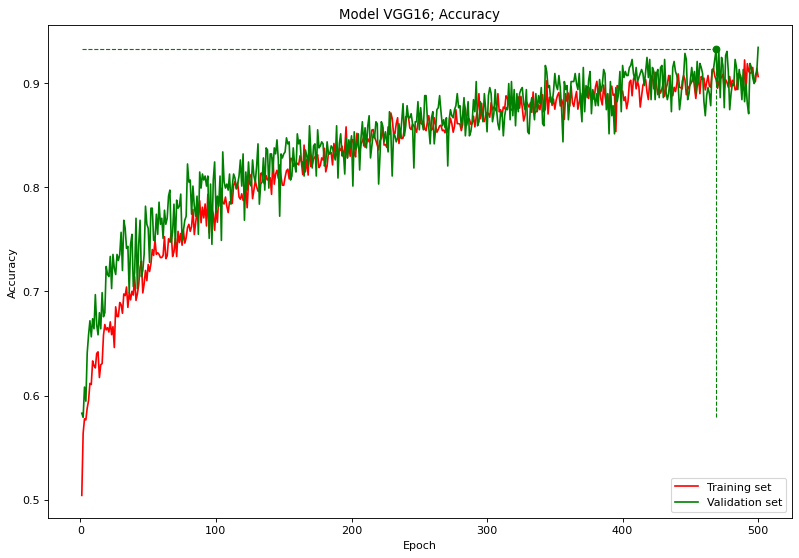

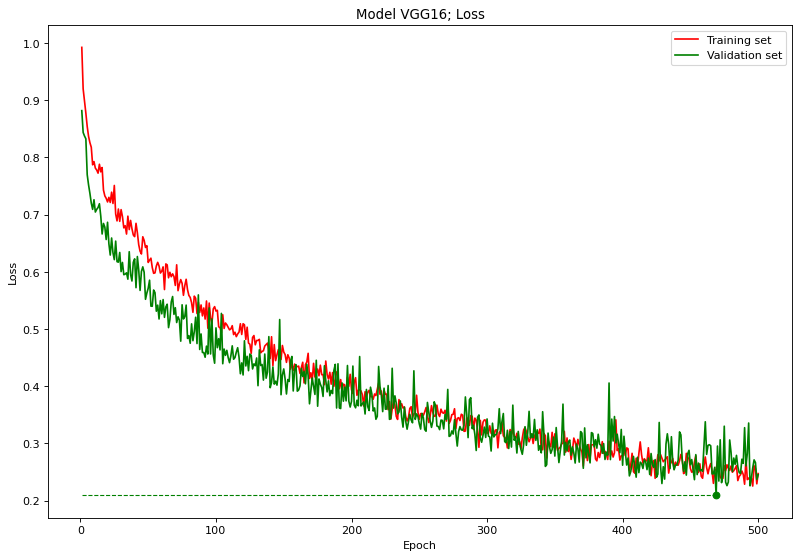

In [51]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model VGG16; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_vgg16_1, tra_acc_vgg16_1, 'r', label='Training set')
plt.plot(epochs_vgg16_1, val_acc_vgg16_1, 'g', label='Validation set')
plt.plot(opt_epoch_vgg16_1, val_acc_vgg16_1[opt_epoch_vgg16_1-1], 'go')
plt.vlines(opt_epoch_vgg16_1, min(val_acc_vgg16_1), opt_val_acc_vgg16_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_vgg16_1, 1, opt_epoch_vgg16_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.savefig('VGG16_1Accuracy_figure.png')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model VGG16; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_vgg16_1, tra_loss_vgg16_1, 'r', label='Training set')
plt.plot(epochs_vgg16_1, val_loss_vgg16_1, 'g', label='Validation set')
plt.plot(opt_epoch_vgg16_1, val_loss_vgg16_1[opt_epoch_vgg16_1-1], 'go')
plt.vlines(opt_epoch_vgg16_1, min(val_loss_vgg16_1), opt_val_loss_vgg16_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_vgg16_1, 1, opt_epoch_vgg16_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();
plt.savefig('VGG16_1Loss_figure.png')

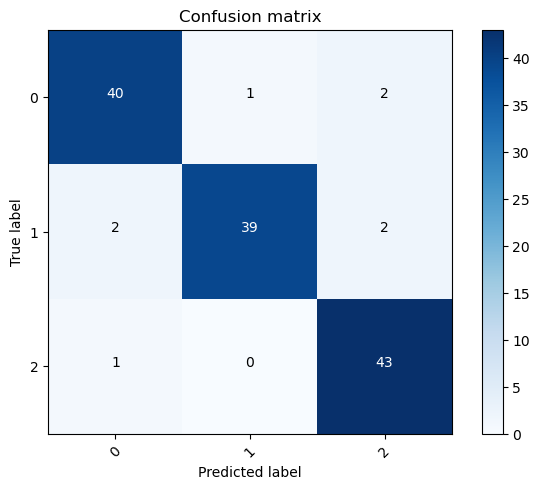

In [52]:
confusion_mtx = confusion_matrix(test_label, pred_classes_vgg16_1) 
plot_confusion_matrix(confusion_mtx, classes=range(3), title='Confusion matrix')
plt.savefig('ConfusionMatrixVGG16_1.png')